# Pennylane wprowadzenie

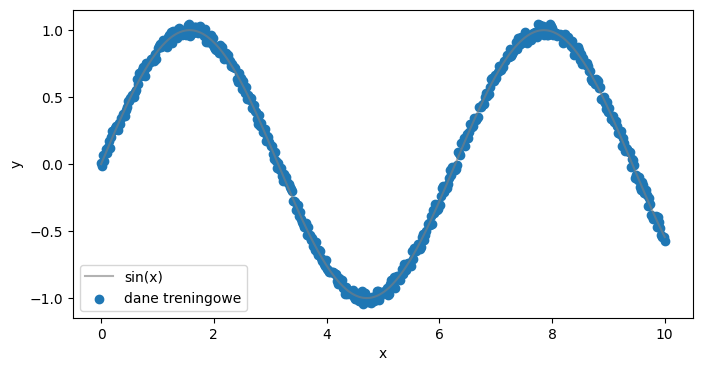

In [1]:
import torch
import matplotlib.pyplot as plt 
from IPython.display import clear_output


x = torch.linspace(0,10,500).view(-1,1)

si = torch.sin(x).view(-1,1)

y = si + 0.1*(torch.rand(500).view(-1,1)-0.5)


plt.figure(figsize=(8,4))
plt.plot(x, torch.sin(x).view(-1,1), color="tab:grey", alpha=0.6, label="sin(x)")
plt.scatter(x, y, label="dane treningowe")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [2]:
class QN(torch.nn.Module):
    '''Classical -> Quantum -> Classical'''

    def __init__(self, N_INPUT: int, N_OUTPUT: int, Q_NODE, N_QUBITS):
        super().__init__()

        self.layers = torch.nn.Sequential(
            # input layer
            torch.nn.Linear(N_INPUT, N_QUBITS),
            # 1st hidden layer as a quantum circuit
            Q_NODE,
            # output layer
            torch.nn.Linear(N_QUBITS, N_OUTPUT)
        )
        

    def forward(self, x):
        return  self.layers(x)

In [24]:
import pennylane as qml

n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layers = 3

weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [25]:
qmodel = QN(1, 1, qlayer, n_qubits)

learning_rate=1e-3

optimiser = torch.optim.Adam(qmodel.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

losses = []

In [26]:
x[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0401],
         [0.0601],
         [0.0802]]),
 tensor([[ 0.0067],
         [-0.0128],
         [ 0.0702],
         [ 0.0238],
         [ 0.1135]]))

In [27]:
qmodel.train()
prediction = qmodel(x)
prediction[:5]

tensor([[-0.3303],
        [-0.3310],
        [-0.3316],
        [-0.3323],
        [-0.3329]], grad_fn=<SliceBackward0>)

In [30]:
def callback(model, loss):
    losses.append(loss.item())

    clear_output(wait=True)
    prediction = model(x).detach()
    plt.figure(figsize=(6,2.5))
    plt.plot(x[:,0].detach(), torch.sin(x)[:,0].detach(), label="Exact solution", color="tab:grey", alpha=0.6)
    plt.plot(x[:,0].detach(), prediction[:,0], label="Classical solution", color="tab:green")
    plt.title(f"Training step {len(losses)}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,2.5))
    plt.title('Lossfn Visualised')
    plt.plot(losses)
    plt.show()


def train(X, Y, model, optimiser, epochs, lossfn, callback = None):
    for _ in range(epochs):
        model.train()
        prediction = model(X)
        loss = lossfn(prediction, Y)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        model.eval()
        if callback != None:
            callback(model, loss)

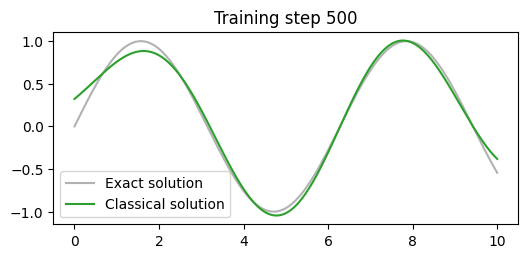

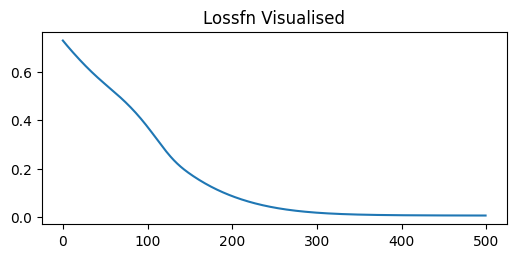

In [31]:
train(x, y, qmodel, optimiser,500, criterion, callback)

## 🧠 PennyLane

🔗 **[Strona oficjalna](https://pennylane.ai)**  

**PennyLane** to otwarto‑źródłowa biblioteka Pythona opracowana przez **Xanadu** dla **kwantowego uczenia maszynowego**, **obliczeń kwantowych** oraz **chemii kwantowej**.  

Zapewnia wysokopoziomowy, intuicyjny interfejs do budowania **hybrydowych modeli kwantowo‑klasycznych**, łącząc obwody kwantowe z popularnymi frameworkami uczenia maszynowego, takimi jak **PyTorch** i **TensorFlow**.

PennyLane wprowadza pojęcie **QNode** (quantum node) – funkcji kwantowych, które zachowują się jak zwykłe funkcje Pythona i obsługują automatyczną różniczkowanie (autodiff).  

Umożliwia uruchamianie modeli zarówno na **symulatorach**, jak i na **rzeczywistym sprzęcie kwantowym** (np. IBM Q, Amazon Braket i inne).

Dzięki PennyLane możesz:
- budować **wariacyjne algorytmy kwantowe**,  
- trenować **kwantowe sieci neuronowe**,  
- eksplorować zaawansowane architektury kwantowego uczenia maszynowego.  

Biblioteka stanowi potężny most między klasyczną sztuczną inteligencją a rosnącym światem obliczeń kwantowych.

PennyLane zawiera także spersonalizowaną wersję **NumPy** (`pennylane.numpy`), która obsługuje **tablice śledzone gradientem**, co ułatwia integrowanie obwodów kwantowych w procesach optymalizacji.


## podstawowe importy bibliotek

In [32]:
import pennylane as qml
import pennylane.numpy as np

### 🧪 Obwody kwantowe w PennyLane

- Obwody kwantowe są implementowane jako **funkcje kwantowe**, zwane także **QNode’ami**.  
  Są to funkcje kwantowe zachowujące się jak standardowe funkcje Pythona i wspierające automatyczną różniczkację przy użyciu klasycznych narzędzi ML.

- QNode’y są uruchamiane na różnych **urządzeniach** (devices), takich jak:

  - **symulatory** (np. `default.qubit`, `lightning.qubit`) oraz,
  - **rzeczywisty sprzęt kwantowy** (np. IBM Q, Amazon Braket, Xanadu).

- Urządzenia są wymienne i określają, w jaki sposób dana funkcja kwantowa jest wykonywana.



![PennyLane](../img/pennylane1.jpg)

🔗 **[Urządzenia, które możesz używać](https://pennylane.ai/devices)**  

Możemy zdefiniować nasz symulator — w tym przypadku użyjemy `default.qubit`.  
Musimy także określić, ile **kubitów** chcemy użyć, korzystając z parametru `wires`.

**Przykładowe urządzenia**

- `default.qubit` – symulator napisany w Pythonie  
- `lightning.qubit` – szybszy symulator napisany w C++  
- `default.mixed` – używany do symulacji **mieszanych stanów kwantowych**

In [36]:
dev = qml.device("default.qubit", wires=1)

In [37]:
## for example 
dev2 = qml.device("default.qubit", wires=3)

dev3 = qml.device("lightning.qubit", wires=['q1', 'aux'])

![kubity1](../img/kubity1.jpg)

$$
\ket{000} = \ket{0}\otimes \ket{0} \otimes \ket{0}
$$

<img src="../img/Qnode.png" />

Obiekt `Qnode` będziemy używać do definicji obwodów kwantowych.
Obiekt ten wspiera wiele bibliotek do obliczeń numerycznych, tzw. interfejsów: 
- `NumPy`, 
- `PyTorch`, 
- `TensorFlow`,
- `JAX`

Domyślnie `QNodes` używa interfejs `NumPy`. Dzięki niemu mamy dostęp do optymalizatorów domyślnych z biblioteki Pennylane. Pozostałe interferjsy wymagają użycia optymalizatorów z innych pakietów. 

In [38]:
def qc(): # quantum circuit
    return qml.state()

wires oznacza kwantowy podsystem - czyli nasz pojedynczy kubit. Liczymy od 0 nie od 1. 

- Funkcja kwantowa może pobierać klasyczne pamaretry 
- Funkcja kwantowa może zawierać klasyczny flow (przepływ) twojego programu `for` czy `if else`.

Zbiór [kwantowych operatorów](https://docs.pennylane.ai/en/stable/introduction/operations.html) 

## Uruchomienie obwodu kwantowego 

Uruchomienie odbywa się po wyborze `device` z określeniem ilości kubitów (wires)

In [39]:
circ = qml.QNode(qc, dev)
circ()

array([1.+0.j, 0.+0.j])

$$
\ket{\psi} = \ket{0} = [1,0]^{T}
$$

In [40]:
circ2 = qml.QNode(qc, dev2)
circ2()

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [41]:
circ3 = qml.QNode(qc, dev3)
circ3()

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [42]:
dev = qml.device("default.qubit", wires=1)

def quantum_circuit():
    qml.Hadamard(wires=0)
    return qml.state()

circ = qml.QNode(quantum_circuit, dev)

circ()

array([0.70710678+0.j, 0.70710678+0.j])

In [43]:
from math import sqrt
print(circ()[0].real, 1/sqrt(2))
print(circ()[0].real == 1/sqrt(2))

0.7071067811865475 0.7071067811865475
True


In [ ]:
qml.draw(circ)()

In [ ]:
qml.draw_mpl(circ)()

Inna wersja 


In [44]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qc():
    qml.Hadamard(wires=0)
    return qml.state()

qc()

array([0.70710678+0.j, 0.70710678+0.j])

Matplotlib is building the font cache; this may take a moment.


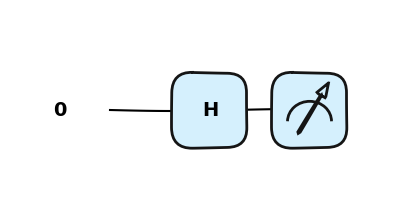

In [45]:
import matplotlib.pyplot as plt

qml.drawer.use_style("pennylane_sketch")

fig, ax = qml.draw_mpl(qc)()
plt.show()

In [46]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qc():
    qml.Hadamard(wires=0)
    return qml.probs()

qc()

array([0.5, 0.5])

DLa pustego obwodu 

In [47]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qc():
    return qml.probs()

results = qc()
results

array([1., 0.])

- użyj `qml.sample()` lub `qml.counts()`  dla innych wariantów wyników. 

Ilość wykonań obwodu sterowana jest w QNode za pomocą parametru `shot`, który może być liczbą jak również listą liczb. 
> Uwaga w wersji biblioteki <0.43 - parametr shot ustawiany jest na poziomie device.

In [48]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev, shots=5)
def qc():
    qml.Hadamard(wires=0)
    return qml.sample()

qc()

array([[1],
       [0],
       [0],
       [0],
       [1]])

In [49]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev, shots=100)
def qc():
    qml.Hadamard(wires=0)
    return qml.counts()

results = qc()

In [50]:
results

{np.str_('0'): np.int64(54), np.str_('1'): np.int64(46)}


Kod naszej wartwy ukrytej w której użyliśmy obwodu kwantowego realizował następujące obiekty i funkcje:
```python

import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
```


`Obwody kwantowe` składają się z rejestrów, które reprezentują poszczególne kubity.

![](../img/kubity1.jpg)

`Domyślnie kubity inicjalizujemy w stanie 0.`

![](../img/kubity2.jpg)



Operacje wykonywane na kubitach nazywamy bramkami.

Operacje te można wykonywać na jednym albo i wielu kubitach na raz.

Domyślnie będziemy optymalizować algortymy aby składały się z jak najmniejszej ilości bramek działających na dużą liczbę kubitów. 


Graficznie można rozumieć realizację algorytmu jako stosowanie bramek na poszczególnych kubitach.

![kibu2](../img/obwod1.png)



W bibliotece PennyLane, `obwody kwantowe` reprezentowane są przez `kwantowe funkcje`, realizowane przez klasyczne funkcje w pythonie. 

Schemat kodu penny lane możemy zapisać jako: 

```python
import pennylane as qml

def my_quantum_function(params):

    # Single-qubit operations with no input parameters
    qml.Gate1(wires=0)
    qml.Gate2(wires=2)

     # Two-qubit operation with no input parameter on wires 0 and 1
    qml.TwoQubitGate1(wires=[0, 1])

    # A single-qubit operation with an input parameter
    qml.Gate3(params[0], wires=2)


    # Two-qubit operation with an input parameter on wires 0 and 1
    qml.TwoQubitGate2(params[1], wires=[1, 2])
    ... 

    # Return the result of a measurement
    return qml.Measurement(wires=[0, 1])
```
Matematycznie całość możemy zapisać jako: 


![](../img/stanpennylane.png)


Przykładowo

![](../img/przyklad1.png)



In [51]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=2)
#dev = qml.device("default.qubit", wires=2, shots=1000)

@qml.qnode(dev)
def circ(theta):
    qml.Hadamard(wires = 0)
    qml.CNOT(wires = [0,1])
    qml.RZ(theta, wires = 0)
    return qml.state()
#    return qml.probs(wires = [0,1])

circ(np.pi)

array([4.32978028e-17-0.70710678j, 0.00000000e+00+0.j        ,
       0.00000000e+00+0.j        , 4.32978028e-17+0.70710678j])

In [52]:
print(qml.draw(circ)(np.pi))

0: ──H─╭●──RZ(3.14)─┤  State
1: ────╰X───────────┤  State


(<Figure size 600x300 with 1 Axes>, <Axes: >)

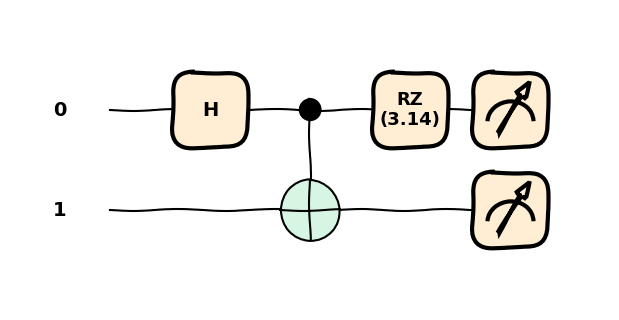

In [53]:
qml.draw_mpl(circ, decimals=2, style="sketch", level="device")(np.pi)

### Bramka X

Bramka X-gate reprezentowana jest przez macierz Pauli-X : 

$$
X = \begin{pmatrix}
0 & 1 \\
1 & 0 \\
\end{pmatrix}
$$


Bramka X obraca kubit w kierunku osi na sferze Bloch'a o $\pi$ radianów.
Zmienia $|0\rangle$ na $|1\rangle$ oraz $|1\rangle$ na $|0\rangle$.
Jest często nazywana kwantowym odpowiednikiem bramki NOT lub określana jako `bit-flip`.

$$ \sigma_x \ket{0} = \ket{1} \,\,\, \sigma_x\ket{1} = \ket{0} $$

In [54]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)
def qc():
    qml.X(wires=0)
    return qml.state()

qc()

array([0.+0.j, 1.+0.j])

In [55]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)
def qc():
    qml.PauliX(wires=0)
    return qml.state()

qc()

array([0.+0.j, 1.+0.j])

(<Figure size 400x200 with 1 Axes>, <Axes: >)

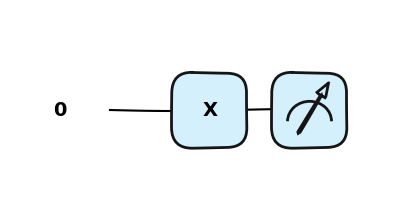

In [56]:
qml.draw_mpl(qc)()

### Bramka Hadamarda 
Bramka Hadamarda przetwarza stan $|0\rangle$ na kombinacje liniowa (superpozycje) $\frac{|0\rangle + |1\rangle}{\sqrt{2}}$, co oznacza, że pomiar zwróci z takim samym prawdopodobieństwem stanu `1` lub `0`. 
Stan ten często oznaczany jest jako: $|+\rangle$. 

$$
H = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1 \\
1 & -1 \\
\end{pmatrix}
$$

$$ H\ket{0} = \frac{\sqrt{2}}{2} (\ket{0}+ \ket{1})$$
$$ H\ket{1} = \frac{\sqrt{2}}{2}(\ket{0}- \ket{1})$$

In [57]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qc():
    qml.Hadamard(wires=0)
    return qml.state()

qc()

array([0.70710678+0.j, 0.70710678+0.j])

obwód z elementami pythona


In [ ]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qc(state):
    if state==1:
        qml.X(wires=0)
    qml.Hadamard(wires=0)
    qml.PauliX(wires=0)
    qml.Hadamard(wires=0)
    return qml.state()

qc(0)

### bramka SX

Bramka SX jest pierwiastkiem kwadratowym bramki X. Dwukrotne zastosowanie powinno reazlizowac bramkę X.

$$
SX = \frac{1}{2}\begin{pmatrix}
1+i & 1-i \\
1-i & 1+i \\
\end{pmatrix}
$$

array([0.5+0.5j, 0.5-0.5j])

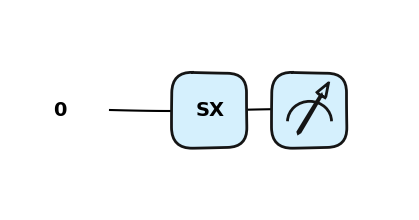

In [58]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)
def qc():
    qml.SX(wires=0)
    return qml.state()

qml.draw_mpl(qc)()
qc()

array([0.+0.j, 1.+0.j])

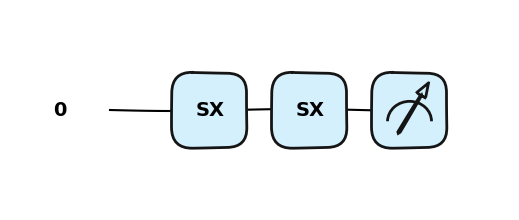

In [59]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)
def qc():
    qml.SX(wires=0)
    qml.SX(wires=0)
    return qml.state()

qml.draw_mpl(qc)()
qc()

### Z gate

$$
Z = \begin{pmatrix}
1 & 0 \\
0 & -1 \\
\end{pmatrix} = \begin{pmatrix}
1 & 0 \\
0 & e^{i \pi} \\
\end{pmatrix}
$$

Inne nazwy bramki: `phase flip` lub `sign flip`

array([ 1.+0.j, -0.+0.j])

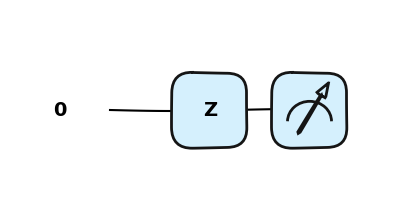

In [60]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)
def qc():
    qml.Z(wires=0)
    return qml.state()

qml.draw_mpl(qc)()
qc()

### RZ gate

Bramkę PauliZ można uogólnić i sparametryzować kątem. Dla $\phi=\pi$ otrzymujemy bramkę $\sigma_z$. 

$$
\begin{pmatrix}
1 & 0 \\
0 & -1 \\
\end{pmatrix} = \begin{pmatrix}
1 & 0 \\
0 & e^{i \pi} \\
\end{pmatrix} = \begin{pmatrix}
1 & 0 \\
0 & e^{i \phi} \\
\end{pmatrix}
$$


$$ R_Z(\phi) = e^{-i \phi \frac{\sigma_z}{2} }  $$

$$
RZ = \begin{pmatrix}
e ^{-i \frac{\phi}{2} } & 0 \\
0 & e ^{i \frac{\phi}{2} } \\
\end{pmatrix} = \cos(\frac{\phi}{2})I_2 - \sin(\frac{\phi}{2}) i\sigma_z
$$

In [61]:
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)


def qc(phi):
    qml.RZ(phi=phi, wires=0)
    return qml.state()

qc(np.pi/2)

array([0.70710678-0.70710678j, 0.        +0.j        ])

(<Figure size 400x200 with 1 Axes>, <Axes: >)

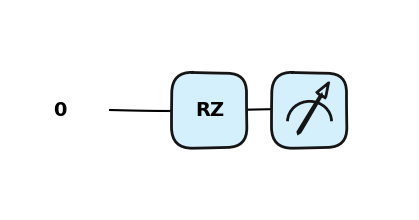

In [62]:
qml.draw_mpl(qc)(np.pi/2)

### CNOT

Jedną z bramek realizującą zadania  na dwóch kubitach jest bramka CNOT, która na bazie bitu kontrolnego decyduje czy zastosować operację X do drugiego kubitu.

$$
\text{CNOT} = \begin{bmatrix} 1 \,\, \,\,\, 0 \,\,\,\,\, 0 \,\,\,\,\, 0 \\ 
0\,\, \,\,\, 1 \,\,\,\,\, 0 \,\,\,\,\, 0 \\
0\,\,\,\,\, 0\,\,\,\,\,  0 \,\,\,\,\, 1 \\ 0\,\,\,\,\, 0\,\,\,\,\, 1\,\,\,\,\, 0 \end{bmatrix}
$$

$$ \text{CNOT} \ket{00} = \ket{00} $$

$$ \text{CNOT} \ket{10} = \ket{11} $$

In [63]:
import pennylane as qml
import pennylane.numpy as np

dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circ(stan='0'):
    if stan == '1':
        qml.X(wires=0)
    qml.CNOT(wires=[0,1])
    # qml.CNOT(wires=[1,0])
    return qml.state()


state = circ()
print(state)

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [64]:
state = circ('1')
print(state)

[0.+0.j 0.+0.j 0.+0.j 1.+0.j]


Magic ;) 

In [66]:
import pennylane as qml
from pennylane import numpy as np 

dev = qml.device('default.qubit', wires=2, shots=100)

@qml.qnode(dev)
def qc():
    # qml.Hadamard(wires=0)
    qml.X(wires=0)
    qml.CNOT(wires=[0,1])
    #return qml.state()
    return qml.counts()

qc()

/Users/seba/Documents/GitHub/technologiekwantowe/.venv/lib/python3.13/site-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


{np.str_('11'): np.int64(100)}

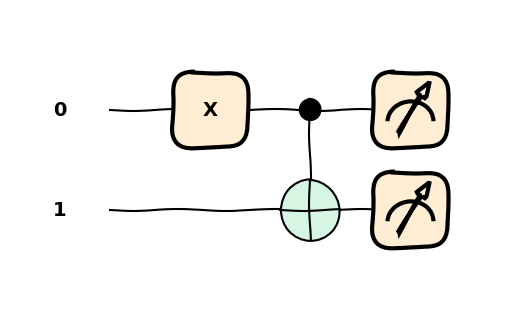

In [67]:
import matplotlib.pyplot as plt
qml.drawer.use_style("sketch")
fig, ax = qml.draw_mpl(qc)()
plt.show()

In [68]:
import pennylane as qml
from pennylane import numpy as np 

dev = qml.device('default.qubit', wires=2, shots=100)

@qml.qnode(dev)
def qc():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    qml.X(wires=1)
    #return qml.state()
    return qml.counts()

qc()

/Users/seba/Documents/GitHub/technologiekwantowe/.venv/lib/python3.13/site-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


{np.str_('01'): np.int64(51), np.str_('10'): np.int64(49)}

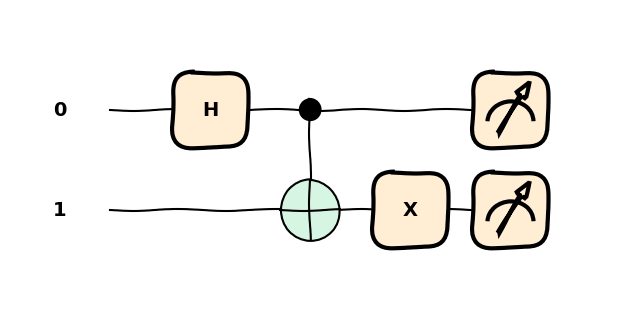

In [69]:
fig, ax = qml.draw_mpl(qc)()
plt.show()

In [70]:
import pennylane as qml
from pennylane import numpy as np 

dev = qml.device('default.qubit', wires=2, shots=100)

@qml.qnode(dev)
def qc():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    qml.X(wires=1)
    qml.Z(wires=1)
    #return qml.state()
    return qml.counts()

qc()

/Users/seba/Documents/GitHub/technologiekwantowe/.venv/lib/python3.13/site-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


{np.str_('01'): np.int64(43), np.str_('10'): np.int64(57)}

## Zadanie -  Obwód kwantowy z optymalizacją

- Napisz nowy obwód kwantowy, który zawierać będzie tylko bramkę $R_X$ dla dowolnego parametru $\theta$
- oblicz i uzasadnij, że wartość oczekiwana dla stanu $\ket{\psi} = R_X \, \ket{0}$ 
$$<Z> = cos^2(\theta /2)- sin^2(\theta /2) = cos(\theta)$$


Załóżmy, że nasz problem obliczeniowy sprowadza się do wygenerowania wartości oczekiwanej o wartości 0.5. 

$$
 \textbf{<Z>} = \bra{\psi} \textbf{Z} \ket{\psi} = 0.5
 $$

 

Napisz program znajdujący rozwiązanie - szukający wagę $\theta$ dla naszego obwodu

- Zdefiniuj funkcję kosztu, którą bedziemy minimalizować $(Y - y)^2$
- zainicjuj rozwiązanie $theta=0.01$ i przypisz do tablicy array `np.array(0.01, requires_grad=True)`
- Jako opt wybierz spadek po gradiencie : `opt = qml.GradientDescentOptimizer(stepsize=0.1)`
- uzyj poniższego kodu do wygenerowania pętli obiczeń 

```python

epochs = 100

for epoch in range(epochs):
    theta = opt.step(cost_fn, theta)

    if epoch % 10 == 0:
        print(f"epoka: {epoch}, theta: {theta}, koszt: {cost_fn(theta)}")
```

In [71]:
import pennylane as qml
from pennylane import numpy as np 

dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def par_c(theta):
    qml.RX(theta, wires=0)
    return qml.expval(qml.PauliZ(0))


def cost_fn(theta):
    return (par_c(theta) - 0.5)**2

theta = np.array(0.01, requires_grad=True)

opt = qml.GradientDescentOptimizer(stepsize=0.1)

epochs = 100

for epoch in range(epochs):
    theta = opt.step(cost_fn, theta)

    if epoch % 10 == 0:
        print(f"epoka: {epoch}, theta: {theta}, koszt: {cost_fn(theta)}")

print(f"Optymalizacja zakonczona dla theta={theta}, koszt: {cost_fn(theta)}")

epoka: 0, theta: 0.010999883335916642, koszt: 0.24993950555333252
epoka: 10, theta: 0.028520883980330904, koszt: 0.2495934725570593
epoka: 20, theta: 0.07380240366299132, koszt: 0.24728524869432472
epoka: 30, theta: 0.18848123038996684, koszt: 0.23260358196368314
epoka: 40, theta: 0.44553231822816797, koszt: 0.1619107886095973
epoka: 50, theta: 0.7954652635692223, koszt: 0.03998102446252434
epoka: 60, theta: 0.9838691671205075, koszt: 0.002894983645374295
epoka: 70, theta: 1.0340365114010706, koszt: 0.00012891702079013002
epoka: 80, theta: 1.0445781695789977, koszt: 5.138079127884816e-06
epoka: 90, theta: 1.0466807535250837, koszt: 2.002500944777545e-07
Optymalizacja zakonczona dla theta=1.0470778036429096, koszt: 1.0753863888581739e-08


In [72]:
import pennylane as qml
from pennylane import numpy as np 

dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev, interface="torch")
def par_c(theta):
    qml.RX(theta, wires=0)
    return qml.expval(qml.PauliZ(0))



def cost_fn(theta):
    target = 0.5
    return (par_c(theta) - target) ** 2


import torch
from torch.optim import Adam 

theta = torch.tensor(0.01, requires_grad=True)

optimizer = Adam([theta], lr=0.1)
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = cost_fn(theta)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"epoka: {epoch}, theta: {theta}, koszt: {cost_fn(theta)}")

epoka: 0, theta: 0.1099998876452446, koszt: 0.24399264948886004
epoka: 10, theta: 1.0454959869384766, koszt: 2.169397961785511e-06
epoka: 20, theta: 1.0966185331344604, koszt: 0.0018829460500888265
epoka: 30, theta: 0.9526112079620361, koszt: 0.006329338284936267
epoka: 40, theta: 1.111649513244629, koszt: 0.0032281231974498922
epoka: 50, theta: 1.0076401233673096, koszt: 0.0011463367423114523
epoka: 60, theta: 1.0690317153930664, koszt: 0.00036201344599675586
epoka: 70, theta: 1.0343401432037354, koszt: 0.000123060304852398
epoka: 80, theta: 1.0549986362457275, koszt: 4.584717916214815e-05
epoka: 90, theta: 1.042211651802063, koszt: 1.859027886217772e-05


Jeszcze jeden przykład

- Napisz obwód kwantowy, który zawierać będzie bramkę $R_X$ dla parametru $\theta_1$ oraz $R_Y$ dla parametru $\theta_2$
- oblicz i uzasadnij, że wartość oczekiwana dla stanu $\ket{\psi} = R_Y(\theta_2) R_X(\theta_1) \, \ket{0}$ 

$$<Z>  = \cos(\theta_1) \cos(\theta_2)$$

Mozliwe wartości średniej zawierają się w przedziale $-1$, $1$.

Przyjmij załozenie, ze optymalne rozwiązanie realizowane jest dla wartości oczekiwanej = 0.4 

In [73]:
import pennylane as qml
from pennylane import numpy as np 

dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def par_c(theta):
    qml.RX(theta[0], wires=0)
    qml.RY(theta[1], wires=0)
    return qml.expval(qml.PauliZ(0))


def cost_fn(theta):
    return (par_c(theta) - 0.4)**2

theta = np.array([0.01, 0.02], requires_grad=True)

opt = qml.GradientDescentOptimizer(stepsize=0.1)

epochs = 100

for epoch in range(epochs):
    theta = opt.step(cost_fn, theta)

    if epoch % 10 == 0:
        print(f"epoka: {epoch}, theta: {theta}, koszt: {cost_fn(theta)}")

print(f"Optymalizacja zakonczona dla theta={theta}, koszt: {cost_fn(theta)}")

epoka: 0, theta: [0.01119924 0.02239872], koszt: 0.3596238551650218
epoka: 10, theta: [0.03468299 0.06939827], koszt: 0.35640059384126277
epoka: 20, theta: [0.10485556 0.21069384], koszt: 0.3277736421372642
epoka: 30, theta: [0.26595847 0.55025891], koszt: 0.17843868824086426
epoka: 40, theta: [0.41114867 0.91214351], koszt: 0.02593550926609833
epoka: 50, theta: [0.45600131 1.05610411], koszt: 0.0017612620807984237
epoka: 60, theta: [0.46619699 1.09390217], koszt: 0.00010074458607215528
epoka: 70, theta: [0.4685347  1.10295946], koszt: 5.557697121461739e-06
epoka: 80, theta: [0.469078   1.10508776], koszt: 3.040948516747214e-07
epoka: 90, theta: [0.46920476 1.10558565], koszt: 1.6607272093790385e-08
Optymalizacja zakonczona dla theta=[0.46923296 1.10569646], koszt: 1.2125189676042736e-09


## klasyczne dane


In [75]:
import pennylane as qml
import pennylane.numpy as np


N = 3
wires = range(N)
dev = qml.device('default.qubit', wires)

In [76]:
@qml.qnode(dev)
def basis_encoding(features):
    qml.BasisEmbedding(features, wires)
    return qml.probs()

In [77]:
basis_encoding([1,1,1])

array([0., 0., 0., 0., 0., 0., 0., 1.])

$$ \ket{111} = \ket{1}\otimes \ket{1} \otimes \ket{1} = [0 0 0 0 0 0 0 1]^T$$


In [78]:
basis_encoding(7)

array([0., 0., 0., 0., 0., 0., 0., 1.])

In [80]:
n_wires = 4 
dev = qml.device('default.qubit', wires= n_wires)

@qml.qnode(dev)
def circ(features):
    for i in range(len(features)):
        if features[i] == 1:
            qml.X(i)
    qml.Barrier()
    qml.Hadamard(1)
    qml.CNOT([1,3])
    return qml.state()

In [81]:
circ([1,0,1,0])

array([0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.70710678+0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

(<Figure size 500x500 with 1 Axes>, <Axes: >)

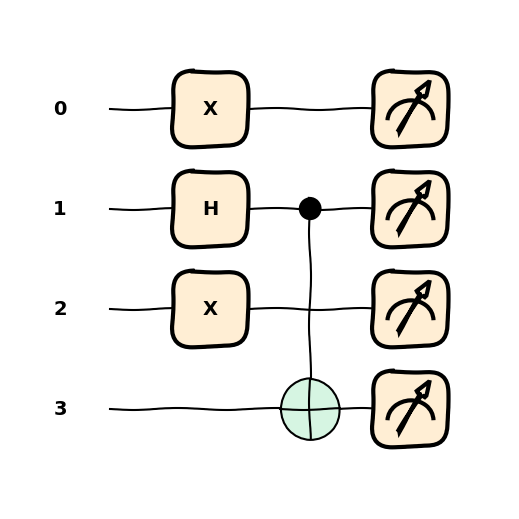

In [82]:
qml.draw_mpl(circ, level='device', scale=0.7)([1,0,1,0])

## Amplitude encoding

In [83]:
import pennylane as qml
N = 3
wires = range(N)

dev = qml.device("default.qubit", wires)

@qml.qnode(dev)
def circuit(features):
    qml.AmplitudeEmbedding(features, wires)
    return qml.state()

In [84]:
circuit([0.625,0.0,0.0,0.0,0.625,0.375,0.25,0.125])

array([0.625+0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.625+0.j, 0.375+0.j,
       0.25 +0.j, 0.125+0.j])

In [85]:
import pennylane as qml
N = 3
wires = range(N)

dev = qml.device("default.qubit", wires)

@qml.qnode(dev)
def circuit(f=None):
    qml.AmplitudeEmbedding(features=f, wires=dev.wires, normalize=True, pad_with=0)
    return qml.expval(qml.PauliZ(0)), qml.state()

In [86]:
vect = [0.1, -0.3, 0.5, 0.4, 0.2]

In [87]:
norm = np.linalg.norm(vect)
norm_vec = np.round([i / norm for i in vect], 4)
print(f"Vec: {vect}, Norm{norm_vec}")

Vec: [0.1, -0.3, 0.5, 0.4, 0.2], Norm[ 0.1348 -0.4045  0.6742  0.5394  0.2697]


In [88]:
res, state = circuit(f=norm_vec)
res2, state2 = circuit(f=vect)

In [89]:
state.real, state2.real

(array([ 0.13479815, -0.40449446,  0.67419077,  0.53939262,  0.26969631,
         0.        ,  0.        ,  0.        ]),
 array([ 0.13483997, -0.40451992,  0.67419986,  0.53935989,  0.26967994,
         0.        ,  0.        ,  0.        ]))

(<Figure size 400x400 with 1 Axes>, <Axes: >)

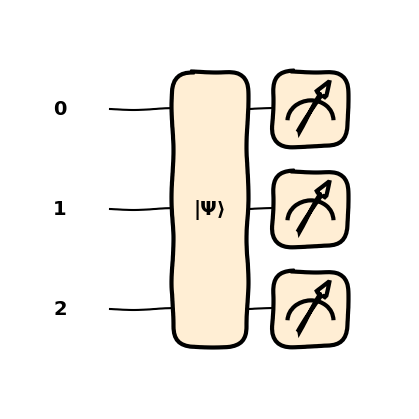

In [90]:
qml.draw_mpl(circuit)(norm_vec)

In [92]:
import pennylane as qml
import pennylane.numpy as np
from sklearn.preprocessing import normalize
from sklearn.datasets import load_wine

data = load_wine()

X = data.data
y = data.target

In [94]:
def prepare_ampl(x, target_len = 16):
    padded = np.pad(x, (0, target_len - len(x)), mode="constant")
    normed = padded / np.linalg.norm(padded)
    return np.array(normed, requires_grad=True)

In [95]:
x0 = X[0]
features = prepare_ampl(x0)

In [97]:
features

tensor([1.32644724e-02, 1.59397384e-03, 2.26512072e-03, 1.45415157e-02,
        1.18382852e-01, 2.61001565e-03, 2.85237424e-03, 2.61001565e-04,
        2.13461994e-03, 5.25731723e-03, 9.69434383e-04, 3.65402190e-03,
        9.92738094e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00], requires_grad=True)

In [98]:
n_qubits = 4
dev = qml.device('default.qubit', wires = n_qubits)

@qml.qnode(dev)
def amplitude_circ(x):
    qml.AmplitudeEmbedding(features=x, wires=range(n_qubits), normalize=False)
    return qml.state()

In [100]:
state = amplitude_circ(features)
state

tensor([1.32644724e-02+0.j, 1.59397384e-03+0.j, 2.26512072e-03+0.j,
        1.45415157e-02+0.j, 1.18382852e-01+0.j, 2.61001565e-03+0.j,
        2.85237424e-03+0.j, 2.61001565e-04+0.j, 2.13461994e-03+0.j,
        5.25731723e-03+0.j, 9.69434383e-04+0.j, 3.65402190e-03+0.j,
        9.92738094e-01+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j], requires_grad=True)

In [101]:
@qml.qnode(dev)
def amp_circ(x):
    qml.AmplitudeEmbedding(features=x, wires=range(n_qubits), normalize=True, pad_with=0)
    return qml.state()

In [102]:
state2 = amp_circ(X[0])
state2

array([1.32644724e-02+0.j, 1.59397384e-03+0.j, 2.26512072e-03+0.j,
       1.45415157e-02+0.j, 1.18382852e-01+0.j, 2.61001565e-03+0.j,
       2.85237424e-03+0.j, 2.61001565e-04+0.j, 2.13461994e-03+0.j,
       5.25731723e-03+0.j, 9.69434383e-04+0.j, 3.65402190e-03+0.j,
       9.92738094e-01+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
       0.00000000e+00+0.j])

## Angle encoding

$$ x \to R_k(x) \ket{0} = e^{-i\,x \frac{\sigma_k}{2}} \ket{0} $$

In [103]:
import pennylane as qml
import pennylane.numpy as np

features= [np.pi/3, np.pi/4]
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circ(features):
    qml.AngleEmbedding(features=features, rotation='Y', wires=range(2))
    return qml.probs(wires=[0,1])

In [104]:
np.round(circ(features), 3)

tensor([0.64 , 0.11 , 0.213, 0.037], requires_grad=True)

(<Figure size 400x300 with 1 Axes>, <Axes: >)

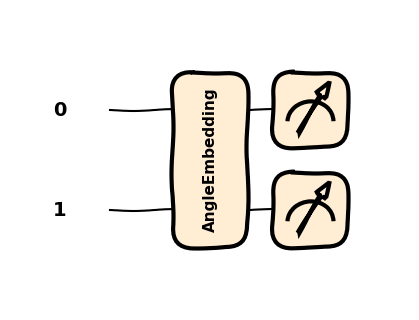

In [105]:
qml.draw_mpl(circ)(features)

In [106]:
import pennylane as qml
import pennylane.numpy as np
from sklearn.preprocessing import normalize
from sklearn.datasets import load_wine

data = load_wine()

X = data.data
y = data.target

In [115]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, np.pi))
X_scaled = scaler.fit_transform(X)

In [117]:
X_scaled[0]

array([2.64555171, 0.60224207, 1.7975958 , 0.80968883, 1.94642154,
       1.97162022, 1.80277047, 0.88913   , 1.86315274, 1.16871536,
       1.43031861, 3.04953133, 1.76350458])

In [120]:
dev = qml.device('default.qubit', wires=13)

@qml.qnode(dev)
def emb(x):
    qml.AngleEmbedding(x, wires=range(len(x)), rotation='Y')
    return qml.expval(qml.PauliZ(0))

In [121]:
emb(X_scaled[0])

np.float64(-0.8794737512064895)

In [122]:
@qml.qnode(dev)
def emb(x):
    qml.AngleEmbedding(x, wires=range(len(x)), rotation='Y')
    return [qml.expval(qml.PauliZ(i)) for i in range(len(x))]

In [123]:
emb(X_saled[0])

[np.float64(-0.8794737512064895),
 np.float64(0.8240675736145868),
 np.float64(-0.2248601123708277),
 np.float64(0.6897237772781044),
 np.float64(-0.3668542188130566),
 np.float64(-0.39017706326055457),
 np.float64(-0.2298992328822939),
 np.float64(0.6300878435817112),
 np.float64(-0.28820944852718955),
 np.float64(0.3913341989876884),
 np.float64(0.14001614496862924),
 np.float64(-0.9957653484788057),
 np.float64(-0.1915177132878786)]

# Modele 


In [124]:
from sklearn.datasets import make_blobs
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [125]:
X, y = make_blobs(n_samples=100, centers=2, random_state=6)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

svm_clf = Pipeline(
    [
        ('scaler', StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss='hinge'))
    ]
)

svm_clf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('linear_svc', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001


In [126]:
print(f"Test acc: {svm_clf.score(X_test, y_test):.2f}")

Test acc: 1.00


/var/folders/53/b8z3c5xs0l51w2mzflnyk6400000gn/T/ipykernel_20306/3794771256.py:17: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(XX, YY, Z, color='k', levels=[-1,0,1], linestyles=['--','-','--'])


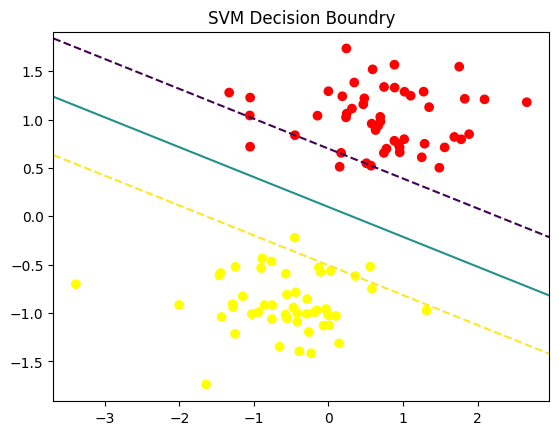

In [127]:
def plot_svm_pipeline(pipeline, X, y):
    scaler = pipeline.named_steps['scaler']
    svc = pipeline.named_steps['linear_svc']
    X_scaled = scaler.transform(X)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='autumn')
    ax = plt.gca()

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = svc.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, color='k', levels=[-1,0,1], linestyles=['--','-','--'])

    plt.title("SVM Decision Boundry")
    plt.show()

plot_svm_pipeline(svm_clf, X, y)

## Kernel trick

Dla prawdziwych danych trudno oczekiwać aby były one liniowo separowalne. 

Dlatego jednym z rozwiązań jest stworzenie odwzorowania do wyżej wymiarowej przestrzeni tak by dane w niej były już liniowo separowalne. Obliczenie takiej transformacji dla dowolnych danych jest bardzo trudne, dlatego możemy zastosować tzw kernel trick. Potrzebujemy tylko obliczyć iloczyn skalarny:
$$ K(x,x') = <\phi(x), \phi(x')>$$
bez jawnego wyznaczania $\phi$.


- x, x' wektory wejściowe z oryginalnej przestrzeni
- $\phi(x)$ odwzorowanie do przestrzeni o wyższym wymiarze
- $K(x, x')$ funkcja jądrowa - kernel function - oblicza iloczy skalarny w zadanej przestrzeni.

1. Linear - $K(x, x') = x^{T}x'$
2. Polynomial - $K(x,x') = (x^{T}x' +c)^d$
3. RBF - $K(x,x') = exp(-\gamma \, |x-x'|^2)$

In [128]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
from sklearn.svm import SVC

X,y = make_moons(n_samples=200, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=44)

poly_svm_clf = Pipeline([
  #  ('polu_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss='hinge'))
])

poly_svm_clf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('linear_svc', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001


In [135]:
print(f"Test acc: {poly_svm_clf.score(X_test, y_test):.2f}")

Test acc: 0.82


In [136]:
linear_svm = SVC(kernel='linear', C=1)
linear_svm.fit(X_train, y_train)
y_pred_linear = linear_svm.predict(X_test)
acc_linear = accuracy_score(y_test, y_pred_linear)

In [137]:
rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)
acc_rbf = accuracy_score(y_test, y_pred_rbf)

In [138]:
def plot_decision_boundry(model, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min(), X[:, 0].max()+1
    y_min, y_max = X[:, 1].min(), X[:, 1].max()+1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

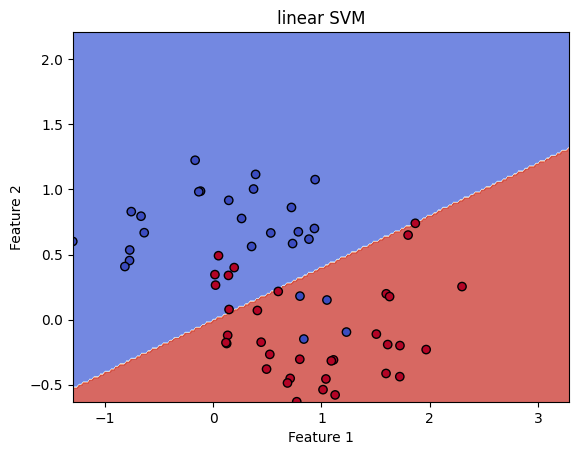

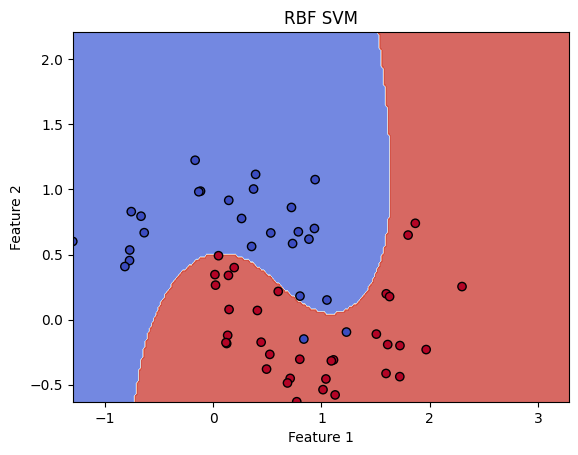

In [139]:
plot_decision_boundry(linear_svm, X_test, y_test, "linear SVM")
plot_decision_boundry(rbf_svm, X_test, y_test, "RBF SVM")

## Idea swap testu

Swap test służy do obliczania wartości

$$ |\langle \psi |\phi \rangle |^2 $$

czyli kwadratu modułu iloczynu skalarnego dwóch stanów kwantowych $|\psi \rangle$ i $|\phi \rangle$ .


### 🔧  Obwód swap testu

Swap test używa dodatkowego kubitu kontrolnego oraz bramki SWAP

Kontrolny kubit realizowany jest w stanie $|0\rangle$.

$$ \ket{\psi_0} = \ket{0} \otimes \ket{\psi} \otimes \ket{\phi} $$

### 🎛️  Jak to działa

- Zastosuj Hadamarda (zamiana bazy) na kontrolny (ancilla) kubit 
$$ \ket{\psi_1} = (\ket{0} + \ket{1}) \otimes \ket{\psi} \otimes \ket{\phi} $$
- Zastosuj CSWAP (3 kubitowa bramka - controll = ancilla)
- Zastosuj Hadamarda (powrót do bazy)
- Pomiar ancilla kubitu.


Prawdopodobieństwo, że kontrolny kubit da wynik $0$, wynosi:
$$P(0)=\frac{1+|\langle \psi |\phi \rangle |^2}{2}$$

Prawdopodobieństwo, że kontrolny kubit da wynik 1, wynosi:
$$P(1)=\frac{1-|\langle \psi |\phi \rangle |^2}{2}$$

Dzięki temu, mierząc kontrolny kubit, możemy wyznaczyć overlap między stanami.


In [ ]:
import pennylane as qml
import pennylane.numpy as np

dev_test = qml.device('default.qubit', wires=['ancilla','phi','psi'], shots=5000)

@qml.qnode(dev_test)
def swap_test():
    qml.Hadamard(wires='ancilla')
    
    qml.X(wires=['phi'])
    qml.Hadamard(wires=['psi'])

    qml.CSWAP(wires=['ancilla', 'phi', 'psi'])
    qml.Hadamard(wires='ancilla')
    return qml.sample(wires='ancilla')

res = swap_test()

print(f"P(0) = {np.mean(res==0)}, P(1) = {np.mean(res == 1)}")
print(f"{2*np.mean(res==0) - 1}")

weryfikacja

In [ ]:
dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def phi():
    qml.X(wires=0)
    return qml.state()

@qml.qnode(dev)
def psi():
    qml.Hadamard(wires=0)
    return qml.state()

def theory(phi, psi):
    inner = np.vdot(phi, psi)
    return float(np.abs(inner)**2)

theory(psi(), phi())

## Quantum Embedding

Kwantowy Embedding reprezentuje klasyczne dane jako stan (wektor) w przestrzeni Hilberta. 
Odwzorowanie, które generuje embedding nazywamy quantum feature map. 

Feature map: $\phi: X \to F$ gdzie $F$ to nowa przestrzeń Hilberta stanów.
$$ x \to \ket{\phi(x)} $$

W naszym przypadku to odwzorowanie realizują $U_{\phi}(x)$ macierze kodowania kątowego. 
$$ \ket{0} \to U_{\phi}(x)\ket{0} $$

In [140]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, np.pi))
X_scaled = scaler.fit_transform(X)

y_scaled = 2 * y -1 

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

Rozważmy model kwantowy w postaci: 
$$ 
f(x) = \braket{\phi(x) | M | \phi{x} } 
$$ 

Model może być realizowany jako _wariacyjny obwód kwantowy_.

Zamiast jednak trenować parametry dla takiego obwodu możemy wykorzystać kwantowy kernel który realizuje się przez SWAP test. 

Zamiast SWAP testu możemy wykorzystać inny obwód [Szczegóły tutaj](https://pennylane.ai/qml/demos/tutorial_kernel_based_training)

In [141]:
from pennylane.templates import AngleEmbedding


n_qubits = 2
dev_kernel = qml.device('lightning.qubit', wires= n_qubits)



projector = np.zeros((2 ** n_qubits, 2 ** n_qubits))
projector[0, 0] = 1

In [142]:
@qml.qnode(dev_kernel)
def kernel(x1, x2):
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

In [144]:
import pennylane.numpy as np 

In [145]:
X_train = np.array(X_train, requires_grad=False)
X_test = np.array(X_test, requires_grad=False)

y_train = np.array(y_train, requires_grad=False)
y_test = np.array(y_test, requires_grad=False)

In [146]:
kernel(X_train[0], X_train[0]), kernel(X_test[0], X_test[1])

(array(1.), array(0.85153324))

In [147]:
def kernel_matrix(A, B):
    return np.array([[kernel(a,b) for b in B] for a in A])

svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)

In [150]:
predictions = svm.predict(X_test)

In [151]:
print(f"model qsvm {accuracy_score(predictions, y_test):.4f}")

model qsvm 0.8400


In [152]:
svm.predict(X_test[:4]), y_test[:4]

(array([-1, -1, -1, -1]), tensor([-1, -1, -1, -1], requires_grad=False))